### Pedestrian dead reckoning for trajectory estimation
Here we compare how GPS tracking compares to dead reckoning. We use a smartphone to gather real GPS and yaw attitude data. We compute (x, y) coordinates from latitude and longitude using spherical geometry, and (x, y) coordinates from yaw by calibrating our walking speed and using path integration.

We find that dead reckoning produces extremely reliable position estimates.

To further improve performance, it is possible to combine GPS and dead reckoning. We can periodically correct our dead reckoning estimates (which have a tendency to drift) using GPS (which is correct on average). A complementary or Kalman filter can be used for this purpose. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from numpy import cos, sin, pi

%matplotlib inline

In [2]:
def load_data(f1='data/lat-long.csv', f2='data/yaw.csv'):
    lat_long = np.loadtxt(fname=f1, delimiter=',')
    yaw = np.loadtxt(fname=f2, delimiter=',')
    lat, long = lat_long[:, 0], lat_long[:, 1]
    return lat, long, yaw

In [3]:
def gen_xy_from_lat_long(lat, long, c0):
    lat_adj = lat - lat[0];
    long_adj = long - long[0];   

    x = -(c0 * cos(lat) / 360) * long_adj
    y = (c0 / 360) * lat_adj
    return x, y

In [4]:
def rotate(x, y, theta):
    c, s = cos(theta), sin(theta)
    rotation = np.array([[c, -s], [s, c]])
    
    xy = np.vstack((x.transpose(), y.transpose()))
    xy = np.dot(rotation, xy)
    return xy[0, :], xy[1, :]

In [5]:
def gen_xy_from_yaw(yaw, dt, v0):
    psiR = yaw
    psi0 = -pi / 2 + yaw[0]

    dxdt = v0 * sin(psi0 - psiR)
    dydt = v0 * cos(psi0 - psiR)

    x = np.cumsum(dt * dxdt)
    y = np.cumsum(dt * dydt)
    return x, y

In [6]:
def shift_and_scale(x1, y1, x2, y2):
    sx = np.mean(x2) - np.mean(x1)
    sy = np.mean(y2) - np.mean(y1)

    alpha_x = (np.max(x2) - np.min(x2)) / (np.max(x1) - np.min(x1))
    alpha_y = (np.max(y2) - np.min(y2)) / (np.max(y1) - np.min(y1))

    x2 = (x2 - sx) / alpha_x
    y2 = (y2 - sy) / alpha_y
    return x2, y2

In [7]:
def plot_navigation(x1, y1, x2, y2, img):
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    titles = ['GPS tracking', 'Yaw attitude', 'Google Maps']

    axarr[0].plot(x1, y1)
    axarr[1].plot(x2, y2)
    axarr[2].imshow(img, aspect='auto')

    for i in range(3):
        axarr[i].set_xticklabels([])
        axarr[i].set_yticklabels([])

        axarr[i].tick_params(axis='both', which='both', length=0)

        axarr[i].set_title(titles[i])
        axarr[i].set_xlabel('East')
        axarr[i].set_ylabel('North')

    fig.tight_layout()
    plt.show()

In [8]:
def main():
    c0 = 40.075 * 1e6;  # Circumference of the Earth (m)
    v0 = 0.97           # Measured walking speed (m/s)
    dt = 0.02           # Interval between yaw samples (s)

    lat, long, yaw = load_data()

    x1, y1 = gen_xy_from_lat_long(lat, long, c0)
    x1, y1 = rotate(x1, y1, -pi / 9)

    x2, y2 = gen_xy_from_yaw(yaw, dt, v0)
    x2, y2 = shift_and_scale(x1, y1, x2, y2)

    img = imread('data/upenn.png')
    plot_navigation(x1, y1, x2, y2, img)

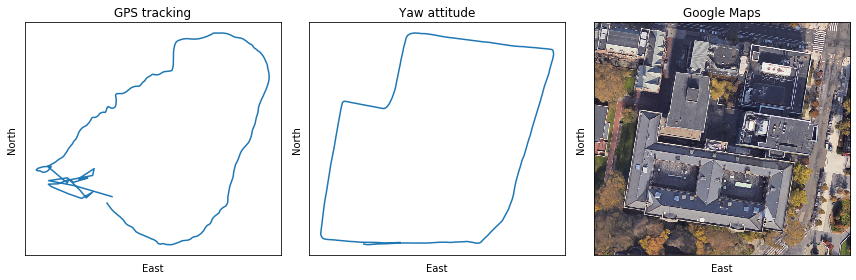

In [9]:
main()